# UNFINISHED - Fitting a zero-inflated Poisson distribution

Can we fit a multi-modal distribution with normalising flows using pytroch?

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl

plt.style.use("seaborn-v0_8-whitegrid")
pl.Config.set_fmt_str_lengths(30)

polars.config.Config

## Generate data

Generate data from a multi-modal distribution. We use a categorical distribution where each component is a distinct Gaussian.

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_88761/1233782845.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


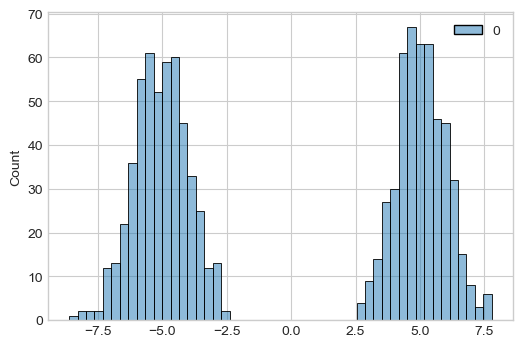

In [41]:
import torch


def generate_data(num_samples):
    mix = torch.distributions.Categorical(torch.tensor([0.5, 0.5]))
    comp = torch.distributions.Normal(
        torch.tensor([-5.0, 5.0]), torch.tensor([1.0, 1.0])
    )
    gmm = torch.distributions.MixtureSameFamily(mix, comp)
    return gmm.sample((num_samples,1))


torch.manual_seed(42)
data = generate_data(1000)

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=data, bins=50, ax=ax)
fig.show()

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Define a simple 2-layer neural network to be used in the flow
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)


# Define a planar flow
class PlanarFlow(nn.Module):
    def __init__(self, input_dim):
        super(PlanarFlow, self).__init__()
        self.u = nn.Parameter(torch.randn(1, input_dim))    # 1 x input_dim, [[...]]
        self.w = nn.Parameter(torch.randn(1, input_dim))
        self.b = nn.Parameter(torch.randn(1))               # 1, [...]

    def forward(self, x):
        linear = x @ self.w.t() + self.b
        activation = torch.tanh(linear)
        psi = (1 - activation**2) @ self.w
        det_jacobian = torch.abs(1 + psi @ self.u.t())
        return x + self.u * activation, torch.log(det_jacobian)


class NormalizingFlow(nn.Module):
    def __init__(self, input_dim, num_flows):
        super(NormalizingFlow, self).__init__()
        self.flows = nn.ModuleList([PlanarFlow(input_dim) for _ in range(num_flows)])
        self.base_mu = nn.Parameter(torch.zeros(input_dim))
        self.base_log_var = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x):
        log_det_jacobian = 0
        for flow in self.flows:
            x, log_det = flow(x)
            log_det_jacobian += log_det
        return x, log_det_jacobian

    def log_prob(self, x):
        z, log_det_jacobian = self.forward(x)
        base_log_prob = -0.5 * (z - self.base_mu).pow(2) / torch.exp(
            self.base_log_var
        ) - 0.5 * torch.log(2 * torch.pi * torch.exp(self.base_log_var))
        return base_log_prob.sum(1) + log_det_jacobian



# Define the flow model
input_dim = 1
num_flows = 5
flow = NormalizingFlow(input_dim, num_flows)
# flow(data)

In [56]:
# Training the normalizing flow
def train_flow(flow, data, num_epochs=1000, lr=0.001):
    optimizer = optim.Adam(flow.parameters(), lr=lr)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = -flow.log_prob(data).mean()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    return flow

# Train the flow model
trained_flow = train_flow(flow, data)

Epoch 0, Loss: 2.02834153175354
Epoch 100, Loss: 1.9907164573669434
Epoch 200, Loss: 1.9076300859451294
Epoch 300, Loss: 1.7958356142044067
Epoch 400, Loss: 1.6932352781295776
Epoch 500, Loss: 1.6181098222732544
Epoch 600, Loss: 1.5474796295166016
Epoch 700, Loss: 1.4981656074523926
Epoch 800, Loss: 1.4741883277893066
Epoch 900, Loss: 1.4611093997955322


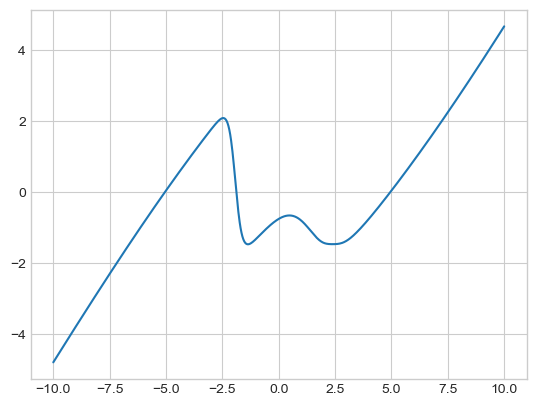

In [58]:
with torch.no_grad():
    z = torch.linspace(-10, 10, 1000).unsqueeze(1)
    transformed_z, _ = flow.forward(z)
    log_prob = flow.log_prob(z)


plt.plot(z.numpy(), transformed_z.numpy(), label="Fitted Distribution")
# z
# transformed_z
# log_prob

Epoch 0, Loss: 1.9154161214828491
Epoch 100, Loss: 1.7085678577423096
Epoch 200, Loss: 1.5931147336959839
Epoch 300, Loss: 1.51778244972229
Epoch 400, Loss: 1.4725109338760376
Epoch 500, Loss: 1.4479172229766846
Epoch 600, Loss: 1.433477520942688
Epoch 700, Loss: 1.4229207038879395
Epoch 800, Loss: 1.4141207933425903
Epoch 900, Loss: 1.4064128398895264


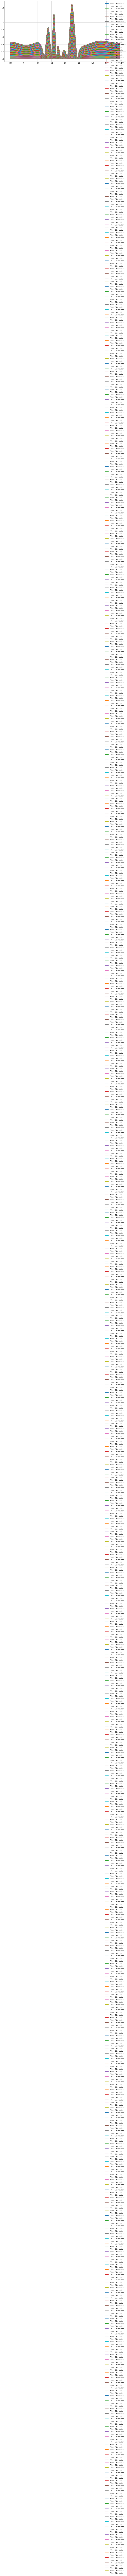

In [48]:


# Plot the results
def plot_results(flow, data):
    with torch.no_grad():
        z = torch.linspace(-10, 10, 1000).unsqueeze(1)
        transformed_z, _ = flow.forward(z)
        log_prob = flow.log_prob(z)

    plt.figure(figsize=(12, 6))
    # plt.hist(data.numpy(), bins=50, density=True, alpha=0.5, label="Data")
    plt.plot(z.numpy(), torch.exp(log_prob).numpy(), label="Fitted Distribution")
    plt.legend()
    plt.show()



# Plot the results
plot_results(trained_flow, data)

In [9]:
flow(data)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1000 and 1x1)

## Generate random data

I'll make random data from two beta distributions and then select from them randomly to get two peaks.
I'll deliberately make the distributions fairly distinct to make the initial analysis easier to visualise.

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_82119/2487205322.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


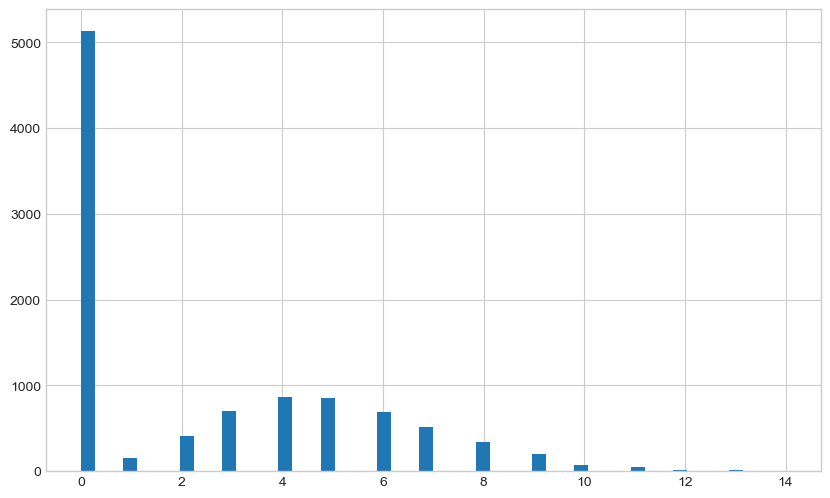

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

# true distribution parameters
p_d1 = 0.5
p_lambda = 5

n = 10000
rand_gen = np.random.default_rng(seed=0)

poisson_samples = rand_gen.poisson(lam=p_lambda, size=(n, 1))
mix_samples = rand_gen.binomial(n=1, p=p_d1, size=(n, 1))
rand_samples = mix_samples * poisson_samples

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(rand_samples, bins=50)
plt.show()

## Creating a PyTorch model

Assuming we know the underlying generating model (...strong assumption...?), we can construct a network that builds the equivalent distribution objects in PyTorch.

We are fitting the distribution parameters.
As such we have no input features for the forward pass, only the output values.
We use negative log likelihood as the loss function to optimise.

In [2]:
import pytorch_lightning as pl
import torch


class ZIPModel(pl.LightningModule):
    def __init__(
        self,
        learning_rate=1e-3,
        init_mix_parameter: float = 0.5,
        init_poisson_lambda: float = 1.0,
    ):
        super().__init__()
        self.mixture_prob = torch.nn.Parameter(torch.tensor([init_mix_parameter]))
        self.poisson_lambda = torch.nn.Parameter(torch.tensor([init_poisson_lambda]))

        self.train_log_error = []
        self.val_log_error = []
        self.mixture_prob_log = []
        self.poisson_lambda_log = []
        self.learning_rate = learning_rate

    def forward(self):
        # ensure correct domain for params
        mixture_prob_norm = torch.sigmoid(self.mixture_prob)
        poisson_lambda_norm = torch.nn.functional.softplus(self.poisson_lambda)
        poisson_lambda_norm = torch.concat(
            (torch.tensor([0.0]), poisson_lambda_norm)
        )  # maintains grad

        mix = torch.distributions.Categorical(
            torch.concat((mixture_prob_norm, 1 - mixture_prob_norm))
        )
        poissons = torch.distributions.Poisson(poisson_lambda_norm)

        mixture_dist = torch.distributions.MixtureSameFamily(mix, poissons)
        return mixture_dist

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        y = batch[0]

        mixture_dist = self.forward()

        negloglik = -mixture_dist.log_prob(y)
        loss = torch.mean(negloglik)

        self.train_log_error.append(loss.detach().numpy())
        self.poisson_lambda_log.append(
            torch.nn.functional.softplus(self.poisson_lambda).detach().numpy()
        )
        self.mixture_prob_log.append(torch.sigmoid(self.mixture_prob).detach().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch[0]

        mixture_dist = self.forward()

        negloglik = -mixture_dist.log_prob(y)
        loss = torch.mean(negloglik)

        self.train_log_error.append(loss.detach().numpy())
        return loss

Lets create the model:

In [3]:
# create model
torch.manual_seed(1)
model = ZIPModel(learning_rate=1e-0, init_mix_parameter=0.5, init_poisson_lambda=4.5)

Now we can generate distribution objects from the model by calling the forward pass method.

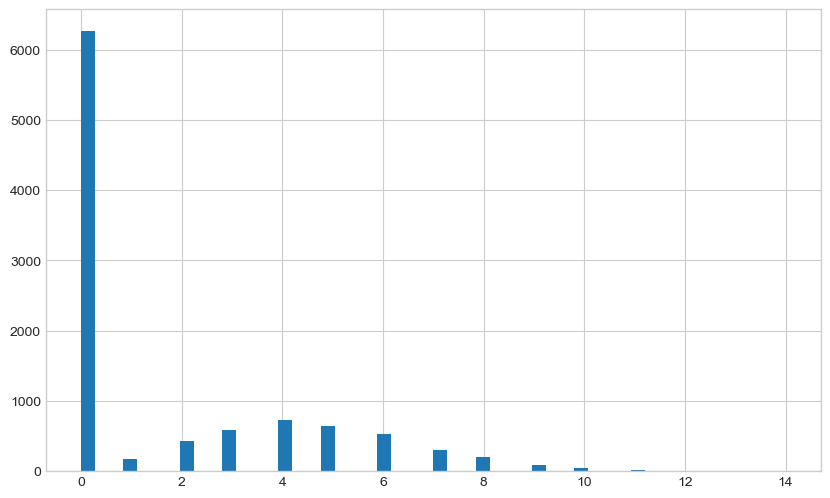

In [4]:
# get some samples
output_dist = model()
output_samples = output_dist.sample((n, 1)).numpy().squeeze()

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(output_samples, bins=50)
plt.show()

## Fitting the model distribution
To train the model with our random sample data created above, we need to setup a dataloader to pass to the trainer.

In [5]:
# training on the whole dataset each batch
from torch.utils.data import TensorDataset, DataLoader

rand_samples_t = torch.Tensor(rand_samples)
dataset_train = TensorDataset(rand_samples_t)
dataloader_train = DataLoader(dataset_train, batch_size=len(rand_samples))

# test loading a batch
rand_samples_batch = next(iter(dataloader_train))
rand_samples_batch[0].shape

torch.Size([10000, 1])

Now we can train the model via PyTorch Lightning's Trainer object.

In [6]:
# fit network
trainer = pl.Trainer(
    max_epochs=100,
)
trainer.fit(model, dataloader_train)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:107: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connecto

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


We can see the training loss has converged ok.

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_82119/2590399248.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


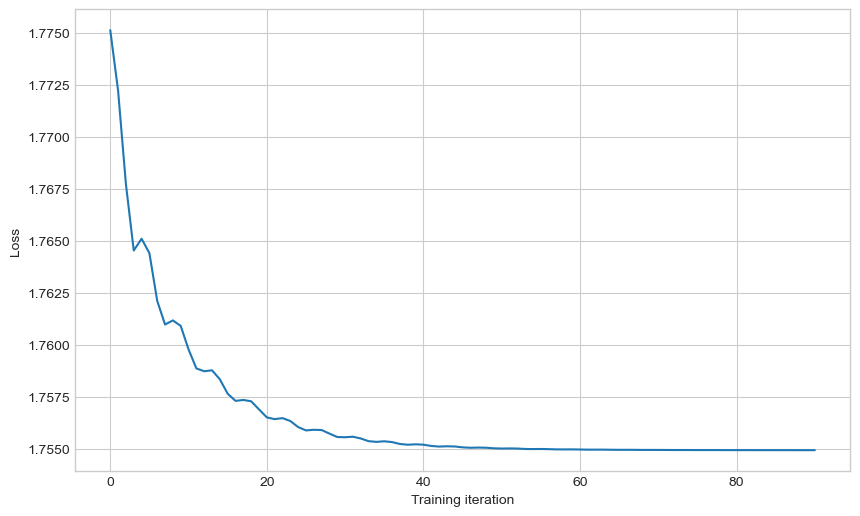

In [7]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(moving_average(np.array(model.train_log_error)))
ax.set_ylabel("Loss")
ax.set_xlabel("Training iteration")
fig.show()

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_82119/2571154232.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


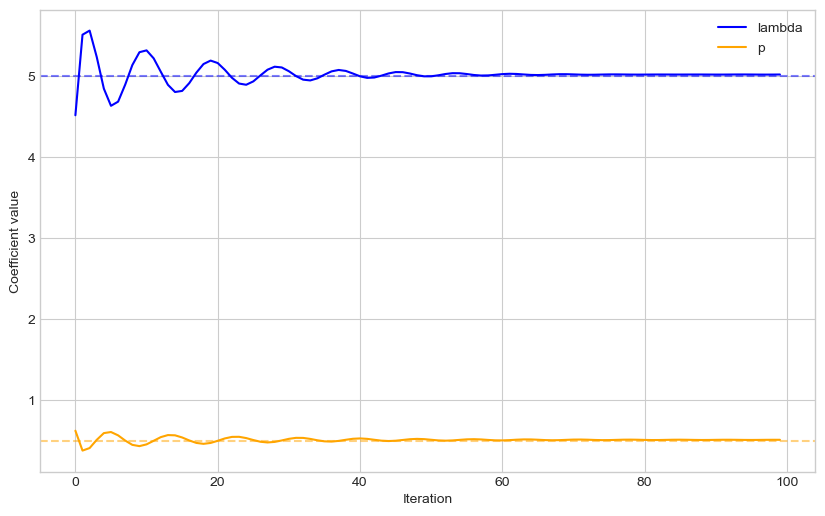

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(model.poisson_lambda_log, color="b", label="lambda")
ax.plot(model.mixture_prob_log, color="orange", label="p")
ax.axhline(y=p_lambda, linestyle="--", color="b", alpha=0.5)
ax.axhline(y=p_d1, linestyle="--", color="orange", alpha=0.5)
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Coefficient value")
fig.show()

## Checking results
Now we can check the resulting distribution that comes out of our model and compare that directly to the random samples.

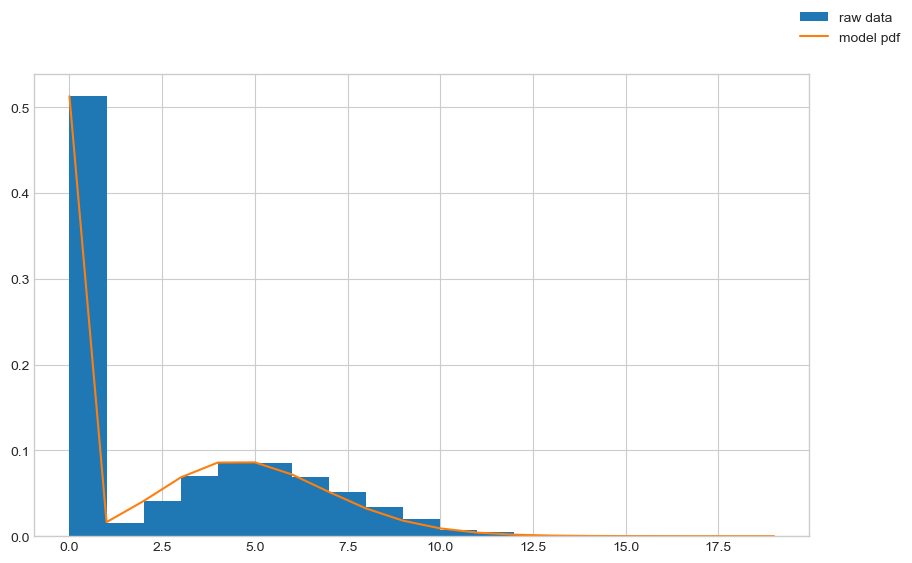

In [9]:
# plot pdf
output_dist = model()
x = torch.arange(0, 20)
y = torch.exp(output_dist.log_prob(x))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(
    rand_samples,
    bins=rand_samples.max() - rand_samples.min(),
    density=True,
    label="raw data",
)
ax.plot(x.detach().numpy(), y.detach().numpy(), label="model pdf")
fig.legend()
plt.show()

We can see that the trained distribution parameters now are close to the underlying parameters.

In [10]:
print("Final mix:", model.mixture_prob_log[-1][0])
print("Final lambda:", model.poisson_lambda_log[-1][0])

print("True mix:", p_d1)
print("True lambda:", p_lambda)

Final mix: 0.5104645
Final lambda: 5.013678
True mix: 0.5
True lambda: 5


### Random seeding
We can start the training from different random initialisations to see how smooth the objective function surface is.

In [11]:
import random

seed_model_params = []
for _idx in range(10):
    print(_idx)
    init_params = [random.random(), random.random() * 10]
    model = ZIPModel(
        learning_rate=1e-0,
        init_mix_parameter=init_params[0],
        init_poisson_lambda=init_params[1],
    )

    # fit network
    trainer = pl.Trainer(
        max_epochs=100,
    )
    trainer.fit(model, dataloader_train)

    seed_model_params.append(
        {
            "err": model.train_log_error[-1],
            "mixture": model.mixture_prob_log[-1],
            "lambda": model.poisson_lambda_log[-1],
            "mixture_init": init_params[0],
            "lambda_init": init_params[1],
        }
    )

0


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


1


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


2


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


3


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


4


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


5


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


6


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


7


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


8


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


9


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [12]:
import pandas as pd

pd.DataFrame(seed_model_params)

,err,mixture,lambda,mixture_init,lambda_init
0,1.7549713,[0.5084596],[4.990373],0.206126,1.271737
1,1.7549436,[0.5095606],[5.0154147],0.957375,5.609975
2,1.75495,[0.50945556],[5.0249567],0.113368,9.019589
3,1.7549486,[0.51113284],[5.019183],0.024360,2.504726
4,1.7549453,[0.50945634],[5.0075474],0.422956,6.300903
5,1.7549646,[0.5087664],[4.992894],0.317083,1.335294
6,1.7549437,[0.50981426],[5.016553],0.569097,3.339710
7,1.7549523,[0.51095116],[5.002224],0.146055,8.153884
8,1.7549479,[0.50936157],[5.022941],0.538195,3.024650
9,1.7549556,[0.50825804],[5.0001493],0.075363,9.901132


Compared with the true parameters, it looks like we're converging well in each case.

So seems successful overall! This approach makes it quite easy to train fairly complex distributions without having to understand the particular methods for fitting that distribution type (if they even exist).

## Creating a PyTorch distribution object

The solution is a bit hacky - we need to define the mixture of two of the same types, so we used a Poisson distribution with a $\lambda$ of 0.
Can we reformulate this is a pytorch distribution class instead?

The poisson class in PyTorch is based around the following (simplified) form:
```python
class Poisson(ExponentialFamily):
    def __init__(self, rate, validate_args=None):
        self.rate = rate
        super(Poisson, self).__init__(batch_shape, validate_args=validate_args)

    def sample(self, sample_shape=torch.Size()):
        with torch.no_grad():
            return torch.poisson(self.rate.expand(shape))

    def log_prob(self, value):
        return value.xlogy(self.rate) - self.rate - (value + 1).lgamma()

    ...
```

Can we build the equivalent zero-inflated Poisson distribution?

We need to specify a `sample` and `log-prob` method. For both of those we need to find an expression for the product mass function (PMF).

### PMF
Poisson PMF:
$$\mathrm{P_{s}}(Y=k | \lambda) = \frac{\lambda^{k} e^{-\lambda }} {k!}$$

Bernoulli PMF:
$$
\begin{align*}
\mathrm{P_{d}}(Y=0) &= \pi\\
\mathrm{P_{d}}(Y!=0) &= 1-\pi
\end{align*}
$$

Mixture distribution:
$$\mathrm{P}(Y) = \mathrm{P_{d}}(Y) \mathrm{P_{s}}(Y)$$

This is the expression we implement to create the `sample` method.


We need to dig further to get the full expression.
The zero case:
$$
\begin{align*}
\mathrm{P}(Y=0) &= \mathrm{P_{d}}(Y=0) + \mathrm{P_{d}}(Y=1) \mathrm{P_{s}}(Y=0 | \lambda)\\
                &= \pi + (1-\pi) \frac{\lambda^{0} e^{-\lambda }} {0!}\\
                &= \pi + (1-\pi) e^{-\lambda }
\end{align*}
$$

The non-zero case:
$$\mathrm{P}(Y=k) = (1-\pi) \frac{\lambda^{k} e^{-\lambda }} {k!}$$

### Log probs
Log of the above:
$$\log{\mathrm{P}(Y=0)} = \log(\pi + (1-\pi) e^{-\lambda })$$

Non zero case:
$$
\begin{align*}
\log{\mathrm{P}(Y=k)} &= \log((1-\pi) \frac{\lambda^{k} e^{-\lambda }} {k!})\\
                      &= \log(1-\pi) + \log(\frac{\lambda^{k} e^{-\lambda }} {k!})\\
                      &= \log(1-\pi) + \log(\lambda^{k} e^{-\lambda }) -\log(k!)\\
                      &= \log(1-\pi) + k\log(\lambda) -\lambda -\log(\Gamma(k+1))
\end{align*}
$$


We can create those expression inside a new class:

In [13]:
from numbers import Number

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import broadcast_all


class ZeroInflatedPoisson(ExponentialFamily):
    arg_constraints = {"p": constraints.unit_interval, "rate": constraints.nonnegative}
    support = constraints.nonnegative_integer

    def __init__(self, p, rate, validate_args=None):
        self.p, self.rate = broadcast_all(p, rate)
        if isinstance(rate, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.rate.size()
        super(ZeroInflatedPoisson, self).__init__(
            batch_shape, validate_args=validate_args
        )

    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            zero = torch.bernoulli(self.p.expand(shape))
            poisson = torch.poisson(self.rate.expand(shape))
            return zero * poisson

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        rate, p, value = broadcast_all(self.rate, self.p, value)
        poisson_log_prob = value.xlogy(rate) - rate - (value + 1).lgamma()
        poisson_log_prob[torch.where(value == 0.0)] = torch.log(
            p + (1 - p) * torch.exp(-rate)
        )[torch.where(value == 0.0)]
        poisson_log_prob[value > 0.0] = (
            torch.log(1 - p)[value > 0.0] + poisson_log_prob[value > 0.0]
        )
        return poisson_log_prob

We can sample from the distribution object and it looks good:

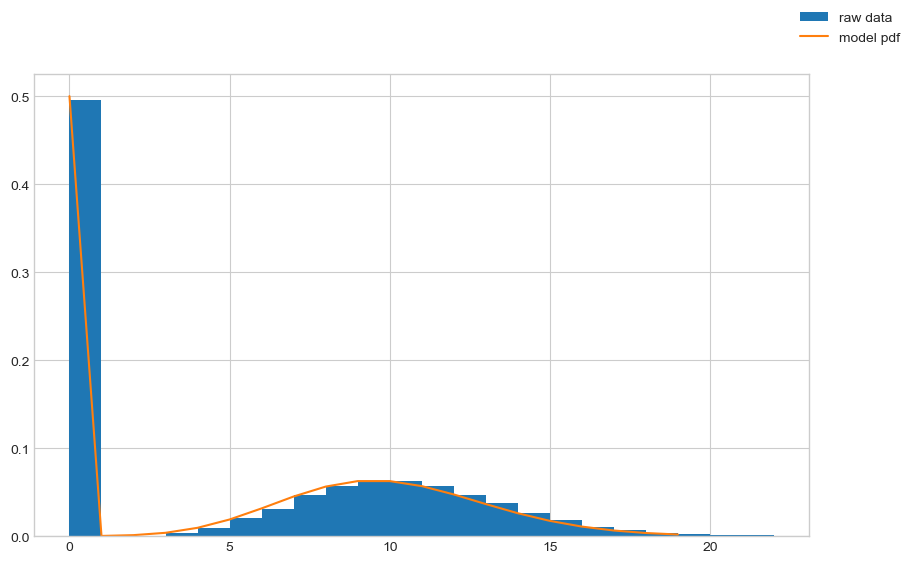

In [14]:
dist = ZeroInflatedPoisson(p=0.5, rate=10.0)
samples = dist.sample(sample_shape=(10000,))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(
    samples, bins=int(samples.max() - samples.min()), density=True, label="raw data"
)

# plot pdf
x = torch.arange(0, 20)
y = torch.exp(dist.log_prob(x))

ax.plot(x.detach().numpy(), y.detach().numpy(), label="model pdf")
fig.legend()
plt.show()

Can we fit the same model with the output as a `ZeroInflatedPoisson`?

We can build the model class with the new distribution object as the output:

In [15]:
class DistZIPModel(ZIPModel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def forward(self):
        # ensure correct domain for params
        mixture_prob_norm = torch.sigmoid(self.mixture_prob)
        poisson_lambda_norm = torch.nn.functional.softplus(self.poisson_lambda)

        zip_dist = ZeroInflatedPoisson(p=mixture_prob_norm, rate=poisson_lambda_norm)
        return zip_dist

Similarly to before, we can then fit the model multiple times from random starting seeds.

In [16]:
import random

seed_model_params = []
for _idx in range(10):
    print(_idx)
    init_params = [random.random(), random.random() * 10]
    model = DistZIPModel(
        learning_rate=1e-0,
        init_mix_parameter=init_params[0],
        init_poisson_lambda=init_params[1],
    )

    # fit network
    trainer = pl.Trainer(
        max_epochs=100,
    )
    trainer.fit(model, dataloader_train)

    seed_model_params.append(
        {
            "err": model.train_log_error[-1],
            "mixture": model.mixture_prob_log[-1][0],
            "lambda": model.poisson_lambda_log[-1][0],
            "mixture_init": init_params[0],
            "lambda_init": init_params[1],
        }
    )

0


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:107: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connecto

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


1


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


2


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


3


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


4


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


5


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


6


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


7


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


8


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


9


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


We get similar results to last time, so the training is working:

In [17]:
import pandas as pd

pd.DataFrame(seed_model_params)

,err,mixture,lambda,mixture_init,lambda_init
0,1.7549562,0.509187,4.996997,0.903635,2.128501
1,1.75495,0.510270,5.002354,0.465512,8.292895
2,1.7549443,0.509034,5.013655,0.527130,5.674198
3,1.7549495,0.510738,5.004287,0.960527,7.272479
4,1.7549485,0.510341,5.022951,0.543747,7.638310
5,1.7549614,0.509203,5.032393,0.378267,0.567890
6,1.7549452,0.509837,5.007850,0.241634,1.943764
7,1.754977,0.508137,5.037724,0.597536,0.653239
8,1.7549465,0.510558,5.019430,0.807217,6.436518
9,1.754944,0.509288,5.011004,0.871826,8.402232


So in summary, we can create a PyTorch distribution class by constructing the `log_prob` of the distribution product mass function. We can then fit that distribution to data via gradient descent without needing to know any particular fitting proceedure for that distribution.